# პროექტის აღწერა

ამ Notebook ში აღწერილია პოპულაციის სეგმენტაციის tool ის დეველოპმენტი და დაწერილია საბოლოო მეთოდები რომელთა საშუალებითაც კლიენტს შეეძლება ნებისმიერი პოპულაციის ნებისმიერი ცვლადებით სეგმენტაცია, ასევე პროექტის მნიშვნელოვანი კომპონენტია ის, რომ მიღებულ სეგმენტების ახსნასაც ეს tool დააგენერირებს მოცემული ცვლადებით. ეს tool გატესტილია რამდენიმე dataset ზე.

პირველადი გეგმა არის შემდეგი:
1. მოცემული ცვლადები აუცილებელია შევკუმშოთ ცოტა ცვლადზე, რადგან სეგმენტების დასაგენერირებლად ვაპირებ KMeans ალგორითმის გამოყენებას, ხოლო მისთვის არსებითად მნიშვნელოვანია ცოტა ცვლადის გამოყენება, რადგან მაღალ განზომილებაში distance ის ცნებას კარგავს და შესაბამისად არსობრივ სეგმენტებს ვეღარ ვიღებთ. ანუ უნდა გამოვიყენოთ PCA. თუ ცვლადების რაოდენობა მეტია 20 ზე, n_components=20 ხოლო თუ ათიდან ოცამდეა n_components=10 რადგან pca ით კატეგორიულების პრობლემასაც ვაგვარებთ(k means clustering ში პირდაპირ ბინარული ცვლადის შეშვება არაა სწორი რადგან სხვა განაწილება აქვს და დისტანციის დათვლის ცნებას აფუჭებს) და ამ ნაწილში იქნება გამოყენების მხრივ ერთადერთი შეზღუდვა - PCA Result >= 70%. ეს გვჭირდება იმისათვის, რომ უზრუნველყოთ კლიენტის მხრიდან მოწოდებულ ცვლადებში არსებული ინფორმაცია რომ PCA ის მიერ გამოყვანილ ცვლადებშიც აისახოს. ანუ გამოყენების მხრივ კლიენტის მხარეს რჩება ის პასუხისმგებლობა, რომ რელევანტური და "კარგი" ცვლადები მოგვცეს. Garbage In, Garbage Out
2. Outliers ის მოშორება. ამ ეტაპზე ამისათვის გამოვიყენებ interquantile range - ს და ამას გავაკეთებ pca ის შემდეგ.
3. Elbow Method/Silhouette Score Analysis - ოპტიმალური კლასტერების რაოდენობის შერჩევა
4. Cluster Description - Decision Tree სტრუქტურის გამოყენებით თითოეული სეგმენტის Description ის დაგენერირება

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

PROJECT_PATH = 'C:/Users/Luka/Documents/University/ML/Final/'
DATA_FOLDER = 'data/'
RANDOM_STATE = 8

# Data Description

In [2]:
cc_df = pd.read_csv(PROJECT_PATH + DATA_FOLDER + 'CC General.csv')

In [3]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
cc_df.shape

(8950, 18)

In [5]:
cc_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Fill Na

missing values ვავსებ შემდეგი ლოგიკით, თუ ცვლადში გვხვდება 0, მაშინ იმ ცვლადში Nan ვავსებ 0-ით. სხვა შემთხვევაში ვავსებ მედიანით.

In [6]:
cc_df.isna().mean()

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.000112
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    0.034972
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

In [7]:
cc_df.columns[1:]

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [8]:
# fills Features that have 0 in it with 0, otherwise with median

vs = pd.DataFrame({'name': cc_df.columns[1:]})
vs['min'] = vs['name'].apply(lambda x: round(cc_df[x].min(), 2))
vs['median'] = vs['name'].apply(lambda x: round(cc_df[x].median(), 2))

for name in list(vs.loc[vs['min'] != 0, 'name'].values):
    cc_df[name] = cc_df[name].fillna(cc_df[name].median())

for name in list(vs.loc[vs['min'] == 0, 'name'].values):
    cc_df[name] = cc_df[name].fillna(cc_df[name].min())

In [9]:
cc_df.isna().mean()

CUST_ID                             0.0
BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
dtype: float64

# PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# interquantile search
def detect_outliers_iqr(df):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include='number').columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR

        outlier_condition = (df[column] < lower_fence) | (df[column] > upper_fence)
        outliers[column] = (outlier_condition).astype(int)

    return outliers.sum(axis=1)

# data - population with features, columnID - column name that is of identifier column
def pca_data(data, columnID, n_components, drop_outliers=False):
    identifiers = data.pop(columnID)

    s = StandardScaler()
    scaled_data = s.fit_transform(data)

    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_data = pca.fit_transform(scaled_data)
    df_pca = pd.DataFrame(pca_data)

    variance_explained = pca.explained_variance_ratio_
    cumulative_variance_explained = np.sum(variance_explained)

    print('PCA Result - ', cumulative_variance_explained)

    # Drops outliers from pca_data using interquantile search
    if drop_outliers:
        pca_count = detect_outliers_iqr(df_pca)
        threshold = pca_count.quantile(0.99)

        print(f'Outlier is point if it is outlier in {threshold} Features')

        identifiers = identifiers[pca_count[pca_count <= threshold].index].reset_index(drop=True)
        df_pca = df_pca.loc[pca_count[pca_count <= threshold].index, :].reset_index(drop=True)
        data = data.loc[pca_count[pca_count <= threshold].index, :].reset_index(drop=True)

    return data, identifiers, df_pca

In [12]:
data, identifiers, df_pca = pca_data(cc_df, 'CUST_ID', 10, True)

PCA Result -  0.9192983251776005
Outlier is point if it is outlier in 5.0 Features


# Elbow Method

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [14]:
def cluster_in_range(df_pca, identifiers, k_range):
    wcss=[]
    diff_clusters = {}

    for n_clusters in k_range:
        kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=RANDOM_STATE)

        cluster_assignments = pd.DataFrame(kmeans.fit_predict(df_pca), columns=['cluster'], index=df_pca.index)
        cluster_assignments['ID'] = identifiers

        diff_clusters[n_clusters] = cluster_assignments['cluster'].value_counts()

        wcss.append(kmeans.inertia_)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    plt.plot(k_range, wcss, marker='o')
    
    plt.xticks(k_range)
    plt.grid()
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    # plt.savefig('num_clust.png')
    plt.show()

    return diff_clusters

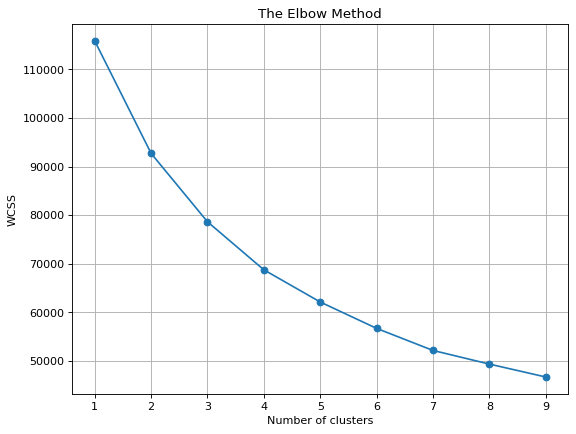

In [15]:
diff_clusters = cluster_in_range(df_pca, identifiers, range(1, 10))

In [16]:
diff_clusters

{1: cluster
 0    8881
 Name: count, dtype: int64,
 2: cluster
 1    5067
 0    3814
 Name: count, dtype: int64,
 3: cluster
 1    4378
 2    3253
 0    1250
 Name: count, dtype: int64,
 4: cluster
 2    3833
 1    3004
 3    1208
 0     836
 Name: count, dtype: int64,
 5: cluster
 4    2952
 0    2824
 1    1337
 2    1015
 3     753
 Name: count, dtype: int64,
 6: cluster
 1    2737
 0    2665
 3    1202
 2     930
 5     709
 4     638
 Name: count, dtype: int64,
 7: cluster
 1    2686
 0    1976
 3    1188
 6    1120
 2     896
 4     622
 5     393
 Name: count, dtype: int64,
 8: cluster
 7    2575
 2    1606
 6    1111
 3    1017
 5     875
 1     718
 4     600
 0     379
 Name: count, dtype: int64,
 9: cluster
 6    2241
 3    1531
 8    1090
 7    1046
 2     976
 0     710
 5     586
 4     367
 1     334
 Name: count, dtype: int64}

# Cluster Description

ამ Tool ის კონტექსტში საუკეთესო ცენტროიდების რაოდენობა მხოლოდ გეომეტრიული ასპექტით არ ფასდება, არამედ რამდენად შეგვიძლია ავხსნათ ეს სეგმენტები. ამისათვის შევიმუშავოთ custom F1-Score ის ცნება. როდესაც Decision Tree ის node ებით ავაწყობთ select ის ლოგიკას, ეს იყოს ჩვენი prediction ბი, ხოლო label იყოს ამ კონკრეტულ კლასტერში ჩავარდნილი წერტილები. ამ განმარტებებიდან გამომდინარე ჩვენ უკვე შეგვიძლია ამ select ის precision, recall - შესაბამისად f1_score ით შევაფასოთ თითოეული კლასტერი. თუ თითოეული კლასტერის შეფასების მეტრიკა გვაქვს, მაშინ შეგვიძლია კონკრეტული k ს შედეგიც შევაფასოთ

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
def get_final_assignments(df_pca, identifiers, k_range):
    final_cluster_assignments = pd.DataFrame(columns=['ID'], index=df_pca.index)
    final_cluster_assignments['ID'] = identifiers
    for n_clusters in k_range:
        best_kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=RANDOM_STATE)
        final_cluster_assignments[f'cluster_{n_clusters}'] = best_kmeans.fit_predict(df_pca)
    return final_cluster_assignments

def generate_description(path, n_nodes, features, is_leaves, children_left, feature, threshold):
    res = ""
    sign = ""
    for i in range(n_nodes):
        if path[i] == 1 and is_leaves[i] != 1:
            if path[children_left[i]] == 1:
                sign = "<"
            else:
                sign = ">"
            res += features[feature[i]] + " " + sign + " " + str(threshold[i]) + ". "
    return res

def get_segment_distributions(final_cluster_assignments, k_range):
    distributions = {}
    for k in k_range:
        if (k-1) not in k_range:
            continue
        dist = {}
        vs = pd.DataFrame(final_cluster_assignments.groupby(f'cluster_{k}')[f'cluster_{k-1}'].value_counts(normalize=True)).reset_index()
        for segment in range(k):
            temp = vs.loc[vs[f'cluster_{k}'] == segment, [f'cluster_{k-1}', 'proportion']]
            temp.index = temp[f'cluster_{k-1}']
            dist.update({segment : temp['proportion']})
        distributions.update({k : dist})
    return distributions
        
def cluster_descriptions(data, df_pca, identifiers, k_range):
    print(f'Whole population are {data.shape[0]} clients.')
    final_cluster_assignments = get_final_assignments(df_pca, identifiers, k_range)
    segment_distributions = get_segment_distributions(final_cluster_assignments, k_range)


    f1_scores = pd.Series()
    
    for n_clusters in k_range:
        print(f"*** Cluster Description for {n_clusters} Clusters ***")
        SEGMENT = [x for x in range(n_clusters)]
        

        print('Cluster Distribution')
        print(final_cluster_assignments[f'cluster_{n_clusters}'].value_counts())

        k_f1_score = 0
        for cluster in SEGMENT:
            # clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=1000, min_impurity_decrease=0.01, random_state=RANDOM_STATE)
            clf = DecisionTreeClassifier(max_depth = 3, min_impurity_decrease=0.01, random_state=RANDOM_STATE)
            
            X = data
            y = (final_cluster_assignments[f'cluster_{n_clusters}'] == cluster).astype(int)

            print(f"  Segment - {cluster} contains {y.sum()} clients, that are {y.mean()} percent of whole population.")

            if (n_clusters - 1) in k_range:
                print(f'From Previous Segments Segment {cluster} Took')
                for index, value in segment_distributions[n_clusters][cluster].items():
                    percent = round(value, 2)
                    if percent == 0:
                        continue
                    print(f'{percent} from Segment {index}')
            
            if y.mean() < 0.09 and y.sum() > 1000:
                rus = RandomUnderSampler(sampling_strategy=0.1, random_state=RANDOM_STATE)
                X, y = rus.fit_resample(X, y)
                print('target undersampled')
            
            clf.fit(X,y)

            n_nodes = clf.tree_.node_count
            children_left = clf.tree_.children_left
            children_right = clf.tree_.children_right
            feature = clf.tree_.feature
            threshold = clf.tree_.threshold
            impurity = clf.tree_.impurity
            n_node_samples = clf.tree_.n_node_samples
            weighted_n_node_samples = clf.tree_.weighted_n_node_samples
            value = clf.tree_.value

            is_leaves = (children_left == children_right)
            classes = np.zeros(n_nodes)
            for i in range(n_nodes):
                if is_leaves[i] != 0:
                    classes[i] = value[i][0][1] > value[i][0][0]

            found_points = {}

            for i in range(n_nodes):
                if classes[i] == 1:
                    found_points.update({i : weighted_n_node_samples[i] * value[i][0][1]})

            max_described_num = 0
            max_described_i = -1
            for key in found_points:
                if found_points[key] > max_described_num:
                    max_described_num = found_points[key]
                    max_described_i = key

            if max_described_i == -1:
                print('Could not Explain This Segment With Less than 4 Features')
                continue
            # Generate Paths To Leaf Nodes That Explains Most of Current Segment

            paths = {}
            leaf_id = pd.DataFrame(clf.apply(X))

            sample_ind = leaf_id[leaf_id[0] == max_described_i].index[0]
            path = clf.decision_path(X[sample_ind:sample_ind + 1]).toarray()
            paths.update({ max_described_i : path})

            # Generate Description
            for i in paths.keys():
                print('** Description **')
                
                print(generate_description(paths[i][0], n_nodes, list(data.columns), is_leaves, children_left, feature, threshold))
                print(f'--------- In given population {weighted_n_node_samples[i]} clients satisfies this filter. From this people, {weighted_n_node_samples[i] * value[i][0][1]} are in Segment {cluster}')
                
                precision = weighted_n_node_samples[i] * value[i][0][1] / weighted_n_node_samples[i]
                recall = weighted_n_node_samples[i] * value[i][0][1] / y.sum()
                f1_score = 2 * ((precision * recall) / (precision + recall))

                k_f1_score += f1_score
                print(f'Precision - {precision}, Recall - {recall}')
                print(f'F1_Score {f1_score}')

        print(f'<-- F1_Score for {n_clusters} clusters is {k_f1_score / n_clusters} -->')
        f1_scores[n_clusters] = k_f1_score / n_clusters
    print(f1_scores)

In [19]:
cluster_descriptions(data, df_pca, identifiers, range(2, 10))

Whole population are 8881 clients.
*** Cluster Description for 2 Clusters ***
Cluster Distribution
cluster_2
1    5067
0    3814
Name: count, dtype: int64
  Segment - 0 contains 3814 clients, that are 0.4294561423263146 percent of whole population.
** Description **
PURCHASES_FREQUENCY > 0.5773810148239136. PURCHASES_FREQUENCY > 0.7207795083522797. 
--------- In given population 3376.0 clients satisfies this filter. From this people, 3258.0 are in Segment 0
Precision - 0.965047393364929, Recall - 0.8542212899842685
F1_Score 0.906258692628651
  Segment - 1 contains 5067 clients, that are 0.5705438576736854 percent of whole population.
** Description **
PURCHASES_FREQUENCY < 0.5773810148239136. 
--------- In given population 4826.0 clients satisfies this filter. From this people, 4697.0 are in Segment 1
Precision - 0.9732697886448405, Recall - 0.9269784882573515
F1_Score 0.9495602951581927
<-- F1_Score for 2 clusters is 0.9279094938934218 -->
*** Cluster Description for 3 Clusters ***
Cl

# Clusterization Tool Class

In [20]:
class ClusterDescriptions:
    def __init__(self, data, df_pca, identifiers, k_range):
        self.k_range = k_range
    
        self.final_cluster_assignments = self.get_final_assignments_class(df_pca, identifiers)
        self.segment_distributions = self.get_segment_distributions_class()

        self.decision_trees = self.get_trees(data)

        self.descriptions = {}

    def get_final_assignments_class(self, df_pca, identifiers):
        final_cluster_assignments = pd.DataFrame(columns=['ID'], index=df_pca.index)
        final_cluster_assignments['ID'] = identifiers
        for n_clusters in self.k_range:
            best_kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=RANDOM_STATE)
            final_cluster_assignments[f'cluster_{n_clusters}'] = best_kmeans.fit_predict(df_pca)
        return final_cluster_assignments

    def get_segment_distributions_class(self):
        distributions = {}
        for k in self.k_range:
            if (k-1) not in self.k_range:
                continue
            dist = {}
            vs = pd.DataFrame(self.final_cluster_assignments.groupby(f'cluster_{k}')[f'cluster_{k-1}'].value_counts(normalize=True)).reset_index()
            for segment in range(k):
                temp = vs.loc[vs[f'cluster_{k}'] == segment, [f'cluster_{k-1}', 'proportion']]
                temp.index = temp[f'cluster_{k-1}']
                dist.update({segment : temp['proportion']})
            distributions.update({k : dist})
        return distributions


    def plot_segment_traffic(self):
        print('Segment Traffic')
        
        for n_clusters in self.k_range:
            print(f"*** Segment Traffic for {n_clusters} Clusters ***")
            print('Cluster Distribution')
            print(self.final_cluster_assignments[f'cluster_{n_clusters}'].value_counts())
            
            SEGMENT = [x for x in range(n_clusters)]

            for cluster in SEGMENT:
                if (n_clusters - 1) in self.k_range:
                    print(f'From Previous Segments Segment {cluster} Took')
                    for index, value in self.segment_distributions[n_clusters][cluster].items():
                        percent = round(value, 2)
                        if percent == 0:
                            continue
                        print(f'{percent} from Segment {index}')
    
    def get_trees(self, data):
        trees = {}
        for n_clusters in self.k_range:
            tree_n = {}
            SEGMENT = [x for x in range(n_clusters)]
        
            for cluster in SEGMENT:
                # clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=1000, min_impurity_decrease=0.01, random_state=RANDOM_STATE)
                clf = DecisionTreeClassifier(max_depth = 3, min_impurity_decrease=0.01, random_state=RANDOM_STATE)
                X = data
                y = (self.final_cluster_assignments[f'cluster_{n_clusters}'] == cluster).astype(int)
                
                if y.mean() < 0.09 and y.sum() > 1000:
                    rus = RandomUnderSampler(sampling_strategy=0.1, random_state=RANDOM_STATE)
                    X, y = rus.fit_resample(X, y)
                
                clf.fit(X,y)

                tree_n[cluster] = clf
                
            trees[n_clusters] = tree_n
        return trees

    def get_max_described_leaf(self, n_clusters, cluster):
        tr = self.decision_trees[n_clusters][cluster]
        
        n_nodes = tr.tree_.node_count
        children_left = tr.tree_.children_left
        children_right = tr.tree_.children_right
        weighted_n_node_samples = tr.tree_.weighted_n_node_samples
        value = tr.tree_.value
        
        is_leaves = (children_left == children_right)
        classes = np.zeros(n_nodes)
        for i in range(n_nodes):
            if is_leaves[i] != 0:
                classes[i] = value[i][0][1] > value[i][0][0]

        found_points = {}

        for i in range(n_nodes):
            if classes[i] == 1:
                found_points.update({i : weighted_n_node_samples[i] * value[i][0][1]})

        max_described_num = 0
        max_described_i = -1
        for key in found_points:
            if found_points[key] > max_described_num:
                max_described_num = found_points[key]
                max_described_i = key

        return is_leaves, max_described_i

    def gen(self, path, n_clusters, cluster, features, is_leaves):
        tr = self.decision_trees[n_clusters][cluster]
        
        n_nodes = tr.tree_.node_count
        children_left = tr.tree_.children_left
        feature = tr.tree_.feature
        threshold = tr.tree_.threshold
        
        res = ""
        sign = ""
        for i in range(n_nodes):
            if path[i] == 1 and is_leaves[i] != 1:
                if path[children_left[i]] == 1:
                    sign = "<"
                else:
                    sign = ">"
                res += features[feature[i]] + " " + sign + " " + str(threshold[i]) + ". "
        return res
        
    def describe_clusters(self, data):
        for n_clusters in self.k_range:
            f1_score = 0
            descriptions_n = {}

            SEGMENT = [x for x in range(n_clusters)]
            for cluster in SEGMENT:
                desc = {}
                tr = self.decision_trees[n_clusters][cluster]
                y = (self.final_cluster_assignments[f'cluster_{n_clusters}'] == cluster).astype(int)
                
                is_leaves, max_described_i = self.get_max_described_leaf(n_clusters, cluster)
    
                if max_described_i == -1:
                    print('Could not Explain This Segment With Less than 4 Features')
                    
                    desc['query'] = 'Could not Explain This Segment With Less than 4 Features'
                    desc['f1_score'] = 0
                    descriptions_n[cluster] = desc
                    
                    continue
                    
                # Generate Paths To Leaf Nodes That Explains Most of Current Segment
                leaf_id = pd.DataFrame(tr.apply(data))
    
                sample_ind = leaf_id[leaf_id[0] == max_described_i].index[0]
                path = tr.decision_path(data[sample_ind:sample_ind + 1]).toarray()
                query = self.gen(path[0], n_clusters, cluster, list(data.columns), is_leaves)

                weighted_n_node_samples = tr.tree_.weighted_n_node_samples
                value = tr.tree_.value
                
                precision = weighted_n_node_samples[max_described_i] * value[max_described_i][0][1] / weighted_n_node_samples[max_described_i]
                recall = weighted_n_node_samples[max_described_i] * value[max_described_i][0][1] / y.sum()
                
                f1_score_n = 2 * ((precision * recall) / (precision + recall))
                f1_score += f1_score_n
                
                desc['query'] = query
                desc['f1_score'] = f1_score_n
                descriptions_n[cluster] = desc
                
            print(f'<-- F1_Score for {n_clusters} clusters is {f1_score / n_clusters} -->')
            self.descriptions[n_clusters] = descriptions_n

In [21]:
cluster_desc = ClusterDescriptions(data, df_pca, identifiers, range(2, 10))

In [22]:
cluster_desc.describe_clusters(data)

<-- F1_Score for 2 clusters is 0.9279094938934218 -->
<-- F1_Score for 3 clusters is 0.8359279158137211 -->
<-- F1_Score for 4 clusters is 0.813619660408545 -->
<-- F1_Score for 5 clusters is 0.8492318123088187 -->
<-- F1_Score for 6 clusters is 0.8450548304020599 -->
<-- F1_Score for 7 clusters is 0.8265913106928438 -->
<-- F1_Score for 8 clusters is 0.8159359737941373 -->
<-- F1_Score for 9 clusters is 0.7900091277640074 -->


ამ score ებიდან ყველაზე კარგი ალბათ 5 კლასტერი იქნებოდა, რადგან ორად დაყოფა შეიძლება ბიზნესურად მომგებიანი არ იყოს.

In [25]:
cluster_desc.plot_segment_traffic()

Segment Traffic
*** Segment Traffic for 2 Clusters ***
Cluster Distribution
cluster_2
1    5067
0    3814
Name: count, dtype: int64
*** Segment Traffic for 3 Clusters ***
Cluster Distribution
cluster_3
1    4378
2    3253
0    1250
Name: count, dtype: int64
From Previous Segments Segment 0 Took
0.88 from Segment 1
0.12 from Segment 0
From Previous Segments Segment 1 Took
0.9 from Segment 1
0.1 from Segment 0
From Previous Segments Segment 2 Took
1.0 from Segment 0
*** Segment Traffic for 4 Clusters ***
Cluster Distribution
cluster_4
2    3833
1    3004
3    1208
0     836
Name: count, dtype: int64
From Previous Segments Segment 0 Took
0.97 from Segment 2
0.03 from Segment 0
From Previous Segments Segment 1 Took
0.8 from Segment 2
0.2 from Segment 1
From Previous Segments Segment 2 Took
0.99 from Segment 1
0.01 from Segment 0
From Previous Segments Segment 3 Took
0.99 from Segment 0
0.01 from Segment 2
*** Segment Traffic for 5 Clusters ***
Cluster Distribution
cluster_5
4    2952
0    

In [26]:
cluster_desc.descriptions

{2: {0: {'query': 'PURCHASES_FREQUENCY > 0.5773810148239136. PURCHASES_FREQUENCY > 0.7207795083522797. ',
   'f1_score': 0.906258692628651},
  1: {'query': 'PURCHASES_FREQUENCY < 0.5773810148239136. ',
   'f1_score': 0.9495602951581927}},
 3: {0: {'query': 'CASH_ADVANCE > 2005.4361572265625. CASH_ADVANCE_TRX > 7.5. ',
   'f1_score': 0.7107039537126326},
  1: {'query': 'PURCHASES_FREQUENCY < 0.7207795083522797. CASH_ADVANCE < 2005.4361572265625. PURCHASES_TRX < 12.5. ',
   'f1_score': 0.8869585911470729},
  2: {'query': 'PURCHASES_FREQUENCY > 0.7207795083522797. CASH_ADVANCE_TRX < 7.5. ',
   'f1_score': 0.9101212025814576}},
 4: {0: {'query': 'PURCHASES > 2709.679931640625. ',
   'f1_score': 0.7870485678704857},
  1: {'query': 'PURCHASES_FREQUENCY > 0.5773810148239136. PURCHASES < 2576.955078125. CASH_ADVANCE < 1489.47509765625. ',
   'f1_score': 0.8914111468744707},
  2: {'query': 'PURCHASES_FREQUENCY < 0.5773810148239136. CASH_ADVANCE < 2870.0909423828125. CASH_ADVANCE_FREQUENCY < 0.4

In [28]:
cluster_desc.descriptions[5]

{0: {'query': 'PURCHASES_FREQUENCY > 0.5773810148239136. PURCHASES < 2730.8299560546875. CASH_ADVANCE < 1795.08837890625. ',
  'f1_score': 0.8834334763948499},
 1: {'query': 'BALANCE_FREQUENCY < 0.6833334863185883. ',
  'f1_score': 0.9228020014295925},
 2: {'query': 'CASH_ADVANCE > 2908.725341796875. ',
  'f1_score': 0.7370030581039755},
 3: {'query': 'PURCHASES > 2740.5750732421875. ',
  'f1_score': 0.805023132848645},
 4: {'query': 'PURCHASES_FREQUENCY < 0.5505054891109467. BALANCE_FREQUENCY > 0.6515154838562012. CASH_ADVANCE < 2881.25732421875. ',
  'f1_score': 0.8978973927670312}}